# Preprocess Data

In this case, data preprocessing stage generates synthetic data to improve model performance when training.

## Ensure Data is Available

In [14]:
! rm -rf dataset
! tar -xzf dataset.tar.gz

## Import packages and functions

In [15]:
import os
import json
import cv2
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt

In [16]:
from utils import utils

In [17]:
TMP_LABEL = "/tmp/ls-label.txt"
UTILS_DIR_PATH = "utils/"
LABELS_INFO = UTILS_DIR_PATH + "labels.json"
DATASET_PATH = "dataset/"
DATA_CONFIG_PATH = "utils/data.yaml"

NB_FRAMES_PER_VIDEO = 10

In [18]:
def generate_dirs():
    os.makedirs(DATASET_PATH, exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/val", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/val", exist_ok = True)

## Visualize Exampl Taffic Signs.

The synthetic data generation algorighm extracts frames from the `utils/video/video1.mp4` file and inserts traffic sign images into those frames

The background of traffic sign images is transparent.

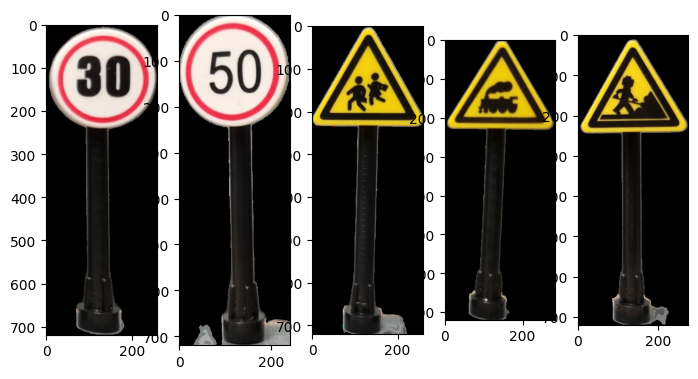

In [19]:
files = [e for e in os.listdir("utils/images") if "lego" in e]
fig = plt.figure(figsize=(10, 7)) 
rows, columns = 1, 6
for i, file in enumerate(files):
    fig.add_subplot(rows, columns, i+1)
    image = cv2.imread("utils/images/"+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## Select Some Images for the Test Set

In [20]:
# Ensure reproducibility
! tar -xzf dataset.tar.gz
random.seed(1)

val_images_dir = Path(DATASET_PATH) / "images" / "val"
val_labels_dir = Path(DATASET_PATH) / "labels" / "val"

test_images_dir = Path(DATASET_PATH) / "images" / "test"
test_labels_dir = Path(DATASET_PATH) / "labels" / "test"

# Select 6 random validation images and corresponding labels
img_files = random.sample([f for f in val_images_dir.iterdir()], 6)
label_files = [val_labels_dir / f.name.replace("jpg", "txt") for f in img_files]

# Clean up test dirs from previous runs
!rm -rf dataset/images/test/*
!rm -rf dataset/labels/test/*

# Move from val to test dir
for f in img_files:
    shutil.move(f, test_images_dir)
for f in label_files:
    shutil.move(f, test_labels_dir)


## Generate Synthetic Data

In [21]:
generate_dirs()
with open(LABELS_INFO) as f:
    label_info = json.load(f)

video_path = UTILS_DIR_PATH + "video/video1.mp4"
random_frames = utils.extract_random_frames(video_path, NB_FRAMES_PER_VIDEO)
num_frames = len(random_frames)

# Iterate on random frames from the video
for i, frame in enumerate(random_frames):
    frame_height, frame_width, _ = frame.shape
    for label in label_info.keys():
        label_id = label_info[label]["label_id"]
        for traffic_sign_info in label_info[label]["children"].values():
            # Insert traffic sign onto frame
            # All possible traffic signs are stored in the utils folder
            image_path = UTILS_DIR_PATH + traffic_sign_info["path"]
            bbox_size = (int(traffic_sign_info["bbox_w"]), int(traffic_sign_info["bbox_h"]))
            inserted_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if inserted_image is None:
                raise Exception("Error: Couldn't load the inserted image file.")
            frame_copy = frame.copy()
            frame_copy, coordinates = utils.insert_image(frame_copy, inserted_image, frame_width, frame_height, bbox_size)

            # Save labels and images in yolo format
            yolo_format = utils.to_yolo_format(frame_width, frame_height, coordinates)
            split = utils.determine_split(i, num_frames)
            utils.add_to_yolo_dataset(frame_copy, split, label_id, label, yolo_format, DATASET_PATH)

### Get Split Sizes

In [22]:
!ls -1 dataset/images/train | wc -l

88


In [23]:
!ls -1 dataset/images/val | wc -l

14


In [24]:
!ls -1 dataset/images/test | wc -l

14


## Visualize Some Synthetic Results

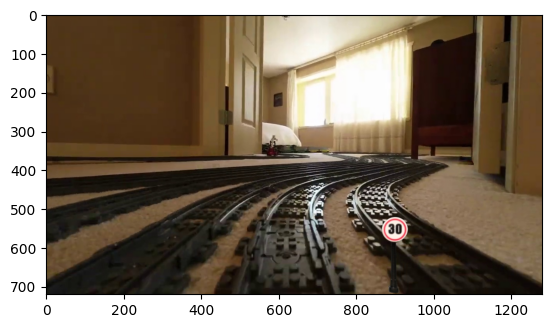

In [27]:
file = random.choice([ f for f in os.listdir("dataset/images/train") if any(match_name in f for match_name in ["SpeedLimit", "DangerAhead"]) ])
image = cv2.imread("dataset/images/train/"+file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## Pack the Extended Dataset

Compress the full dataset in a tar.gz file. The training step will use this file to train the model.

In [26]:
! tar -czf dataset-full.tar.gz dataset